In [1]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams, Catlab.Graphics.Graphviz
using Catlab.Graphics.Graphviz: Html
using AlgebraicPetri

In [27]:
# Functions for graphing typed Petri nets
colors = ["#a08eae","#ffeec6", "#a8dcd9", "#ffeec6", "#a8dcd9"]

function def_trans(typed_petri::ACSetTransformation, colors; labels = true)
  (p, t; pos = "") -> ("t$t", Attributes(
             :label => labels ? Html(flatten(tname(p,t))) : "" ,
             :shape=>"square",
             :color=>colors[typed_petri[:T](t)],
             :pos=>pos))
end

function def_trans(colors = colors; labels = true)
  (p, t; pos = "") -> ("t$t", Attributes(
             :label => labels ? "$(tname(p, t))" : "" ,
             :shape=>"square",
             :color=>colors[t],
             :pos=>pos))
end

flatten(tname::Symbol) = "$tname"

function flatten(tname::Tuple)
    names = split(replace(string(tname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_states(p, s; pos="") = ("s$s", Attributes(
        :label => sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
        :shape=>"circle",
        :color=>"#6C9AC3",
        :pos=>pos
))

Graph_typed(typed_petri::ACSetTransformation, colors = colors; labels = true) = Graph(dom(typed_petri),
    make_trans = def_trans(typed_petri, colors; labels = labels),
    make_states = def_states
)


Graph_typed (generic function with 2 methods)

# Type systems for open Petri nets

This notebook showcases typed Petri nets and their application in generating stratified models. It reproduces the examples in Section 3 of *An Algebraic Framework for Structured Epidemic Modeling*.

## Typed Petri nets
We establish two Petri nets which are domain-specific type systems for epidemiological modeling.

$P_\mathsf{infectious}$ represents a type system for infectious diseases. It has one place representing a single population and three transitions:
1. `interact` representing an interaction between two individuals.
2. `t_disease` representing a spontaneous change in disease status.
3. `t_strata` representing a spontaneous change in strata.

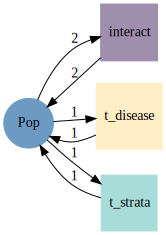

In [28]:
infectious_type = LabelledPetriNet([:Pop],
  :interact=>((:Pop, :Pop)=>(:Pop, :Pop)), 
  :t_disease=>(:Pop=>:Pop),
  :t_strata=>(:Pop=>:Pop)
)

Graph_typed(id(infectious_type))

On the other hand, $P_\mathsf{vector-borne}$ respresents a types sytem for vector-borne diseases. It has two places representing a host and a vector population. The transitions `t_disease` and `t_strata` represent spontaneous changes in disease and strata status for hosts and vectors. The single `interact` transition represents an interaction between a host and a vector. 

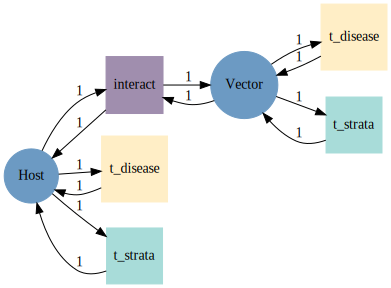

In [29]:
vector_borne_type = LabelledPetriNet([:Host, :Vector],
  :interact=>((:Host, :Vector)=>(:Host, :Vector)),
  :t_disease=>(:Host=>:Host),
  :t_strata=>(:Host=>:Host),
  :t_disease=>(:Vector=>:Vector),
  :t_strata=>(:Vector=>:Vector)
)

Graph(vector_borne_type; make_trans = def_trans())

A Petri net typed by $P_\mathsf{infectious}$ is a Petri net $P$ along with an etale map $P \to P_{\mathsf{infectious}}$, which is captured by the data of an ACSetTransformation.

To make these ACSetTransformations easier to define, we begin by extracting data from the type system $P_\mathsf{infectious}$.

In [30]:
s, = parts(infectious_type, :S)
t_interact, t_disease, t_strata = parts(infectious_type, :T)
i_interact1, i_interact2, i_disease, i_strata = parts(infectious_type, :I)
o_interact1, o_interact2, o_disease, o_strata = parts(infectious_type, :O);

infectious_type = map(infectious_type, Name=name->nothing); # remove names to allow for the loose ACSet transform to be natural

Our first example of a typed Petri net is the classic SIR model of disease infection.
There are three places that are all typed by the single place type `Pop`, and five transitions. The transition labeled `inf` represents an infection between a susceptible and an infected individual. The transition labeled `rec` represents recovery of an infected individual. The transitions labeled `id` represent identity transformations or no change in disease status. However, they are important because in a stratification they may be paired with transitions that represent spontaneous change in strata. 

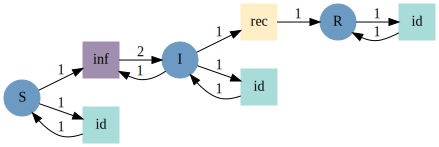

In [31]:
SIR = LabelledPetriNet([:S, :I, :R],
  :inf => ((:S, :I)=>(:I, :I)),
  :rec => (:I=>:R),
  :id => (:S => :S),
  :id => (:I => :I),
  :id => (:R => :R)
)

typed_SIR = ACSetTransformation(SIR, infectious_type,
  S = [s, s, s],
  T = [t_interact, t_disease, t_strata, t_strata, t_strata],
  I = [i_interact1, i_interact2, i_disease, i_strata, i_strata, i_strata],
  O = [o_interact1, o_interact2, o_disease, o_strata, o_strata, o_strata],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
);


@assert is_natural(typed_SIR)

Graph_typed(typed_SIR)

Our second example is of a stratification scheme for stratification by quarantine status. It contains a population of individuals in quarantine/isolation $Q$ and a population of individuals not in quarantine/isolation $Q^f$.
Individuals can move between these strata and also undergo a spontaneous change in their infection status.
However, interaction-type transformations can only occur between two individuals in the non-quarantining population.

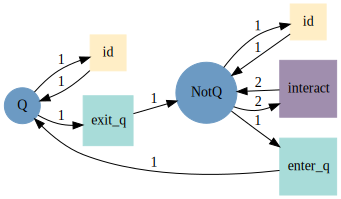

In [32]:
quarantine = LabelledPetriNet([:Q, :NotQ],
    :id => (:Q => :Q),
    :id => (:NotQ => :NotQ),
    :enter_q => (:NotQ => :Q),
    :exit_q => (:Q => :NotQ),
    :interact => ((:NotQ, :NotQ) => (:NotQ, :NotQ))
)

typed_quarantine = ACSetTransformation(quarantine, infectious_type,
    S = [s, s],
    T = [t_disease, t_disease, t_strata, t_strata, t_interact],
    I = [i_disease, i_disease, i_strata, i_strata, i_interact1, i_interact2],
    O = [o_disease, o_disease, o_strata, o_strata, o_interact1, o_interact2],
    Name = name -> nothing
)

@assert is_natural(typed_quarantine)

Graph_typed(typed_quarantine)

## Model stratification

This section presents examples of stratifying one typed model by another to build multi-faceted models.

### First example

First, we give methods to produce the stratified model of two typed Petri nets.
`stratify` returns the stratified model while `typed_stratify` returns the stratified model along with a typing of it.

Mathematically, these operations correspond to pullbacks, and the `pullback` method is implemented by Catlab.jl. Graphically, you can see a pullback as shown in the following figure:

<img width = 40% src="img/pullback.png">

In [33]:
stratify(typed_model1, typed_model2) = ob(pullback(typed_model1, typed_model2))

typed_stratify(typed_model1, typed_model2) =
  compose(proj1(pullback(typed_model1, typed_model2)), typed_model1);

We apply this method to the SIR and quarantining models. Note that the labels of the places and transitions are pairs with the first element in the pair representing information from the disease model and the second element in the pair representing information from the stratification scheme. For example, the place labeled `(:S, :Q)` represents the population of susceptible individuals who are in quarantine.  The transitions labeled `(:id, :exit_q)` represents no change (i.e. identity transformation) in disease status and a change in strata from quarantining to not quarantining. The transition labeled `(:inf, :interaction)` represents the infection interaction between two individuals who are not quarantining.

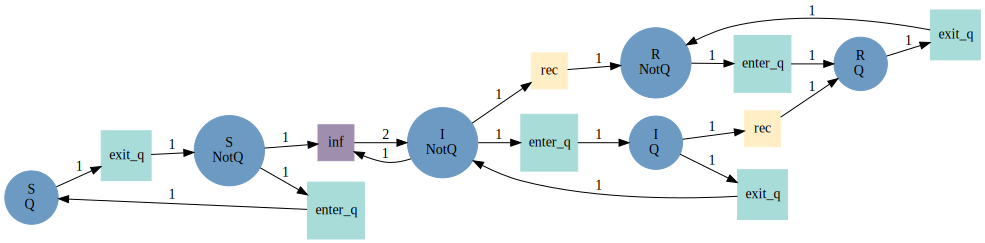

In [34]:
typed_stratified_model = typed_stratify(typed_SIR, typed_quarantine)
Graph_typed(typed_stratified_model)

The layout engine used by Graphviz doesn't know about the pullback structure, so it doesn't generate a nice symmetric layout. Future work could explore algorithms for Petri net layout that use this structure. Below is the same Petri net but with a more systematic layout.

<img width = 80% src="img/sirquarantine.png">

### Example playground
Next we give a palette of disease models and a palette of stratification schemes.
These can be used to derive a number of stratified models as well as multiply-stratified models

#### Palette of disease models

Our palette of disease models includes the SIR model implemented above along with the SIS and SVIIvR model pictured below:

<img width = 60% src="img/palette-disease.png">

Next, we describe and implement these additional disease models.

Our second disease model is the Susceptible-Infected-Susceptible (SIS) model of disease infection, in which
there is no long-lasting immunity and a recovered indivdual is susceptible to reinfection.

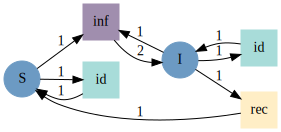

In [35]:
SIS = LabelledPetriNet([:S, :I],
  :inf => ((:S, :I)=>(:I, :I)),
  :rec => (:I=>:S),
  :id => (:S => :S),
  :id => (:I => :I),
)

typed_SIS = ACSetTransformation(SIS, infectious_type,
  S = [s, s],
  T = [t_interact, t_disease, t_strata, t_strata],
  I = [i_interact1, i_interact2, i_disease, i_strata, i_strata],
  O = [o_interact1, o_interact2, o_disease, o_strata, o_strata],
  Name = name -> nothing
);

@assert is_natural(typed_SIS)

Graph_typed(typed_SIS)

The third disease model is the SVIIvR model defined compositionally and discussed in detail in [composition.ipynb](https://github.com/AlgebraicJulia/Structured-Epidemic-Modeling/blob/main/composition.ipynb). To this model we add identity transformations between each place that are typed by spontaneous change in strata.

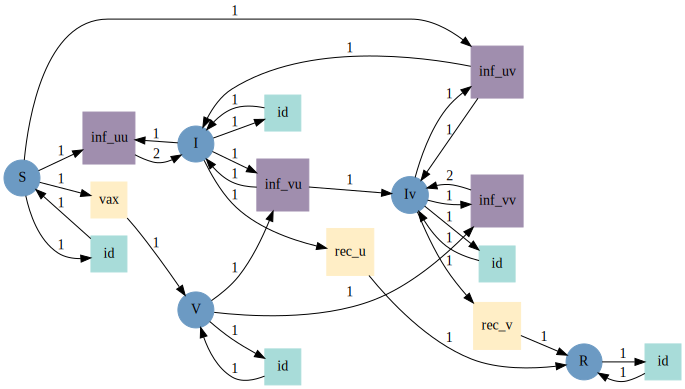

In [36]:
SVIIvR_composition_pattern = @relation (S, V, I, Iv, R) where (S, V, I, Iv, R) begin
  SIR(S, I, R)
  VIvR(V, Iv, R)
  cross_exposure(S, I, V, Iv)
end

SIR = Open(LabelledPetriNet([:S, :I, :R],
  :inf_uu => ((:S, :I) => (:I, :I)),
  :rec_u => (:I => :R)
))

VIvR = Open(LabelledPetriNet([:V, :Iv, :R],
  :inf_vv => ((:V, :Iv) => (:Iv, :Iv)),
  :rec_v => (:Iv => :R)
))

cross_exposure = Open(LabelledPetriNet([:S, :I, :V, :Iv],
  :inf_uv => ((:S, :Iv) => (:I, :Iv)),
  :inf_vu => ((:V, :I) => (:Iv, :I)),
  :vax => (:S => :V)
))

SVIIvR = oapply(SVIIvR_composition_pattern, Dict(
  :SIR => SIR,
  :VIvR => VIvR,
  :cross_exposure => cross_exposure
)) |> apex;

ts = add_transitions!(SVIIvR, ns(SVIIvR), tname = :id)
add_inputs!(SVIIvR, ns(SVIIvR), ts, 1:ns(SVIIvR))
add_outputs!(SVIIvR, ns(SVIIvR), ts, 1:ns(SVIIvR));

typed_SVIIvR = ACSetTransformation(SVIIvR, infectious_type,
  S = [s, s, s, s, s],
  T = vcat([t_interact, t_disease, t_interact, t_disease,  t_interact, t_interact, t_disease], repeat([t_strata], 5)),
  I = vcat([i_interact1, i_interact2, i_disease, i_interact1, i_interact2, i_disease, i_interact1, i_interact2, i_interact1, i_interact2, i_disease], repeat([i_strata], 5)),
  O = vcat([o_interact1, o_interact2, o_disease, o_interact1, o_interact2, o_disease, o_interact1, o_interact2, o_interact1, o_interact2, o_disease], repeat([o_strata], 5)),
  Name = name -> nothing
);

@assert is_natural(typed_SVIIvR)

Graph_typed(typed_SVIIvR)

Finally, we define our palette of disease models.

In [37]:
disease_models = Dict(
  :SIR => typed_SIR,
  :SIS => typed_SIS,
  :SVIIvR => typed_SVIIvR,
);

We can stratify each of these disease models by the model of quarantining. Note that we omit the labels on the transition to reduce the size of the Petri net. Recall that blue transitions correspond to spontaneous changes in strata, yellow transitions correspond to spontaneous changes in disease status, and purple transitions correspond to interactions.

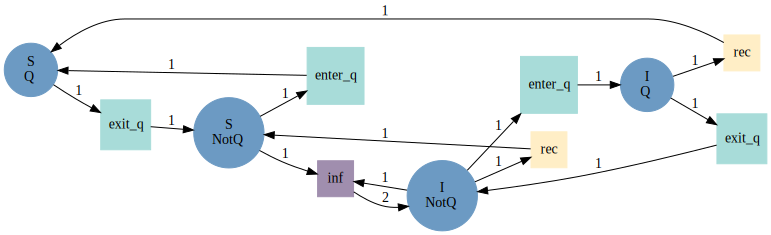

In [38]:
typed_model = typed_stratify(disease_models[:SIS], typed_quarantine)
Graph_typed(typed_model)

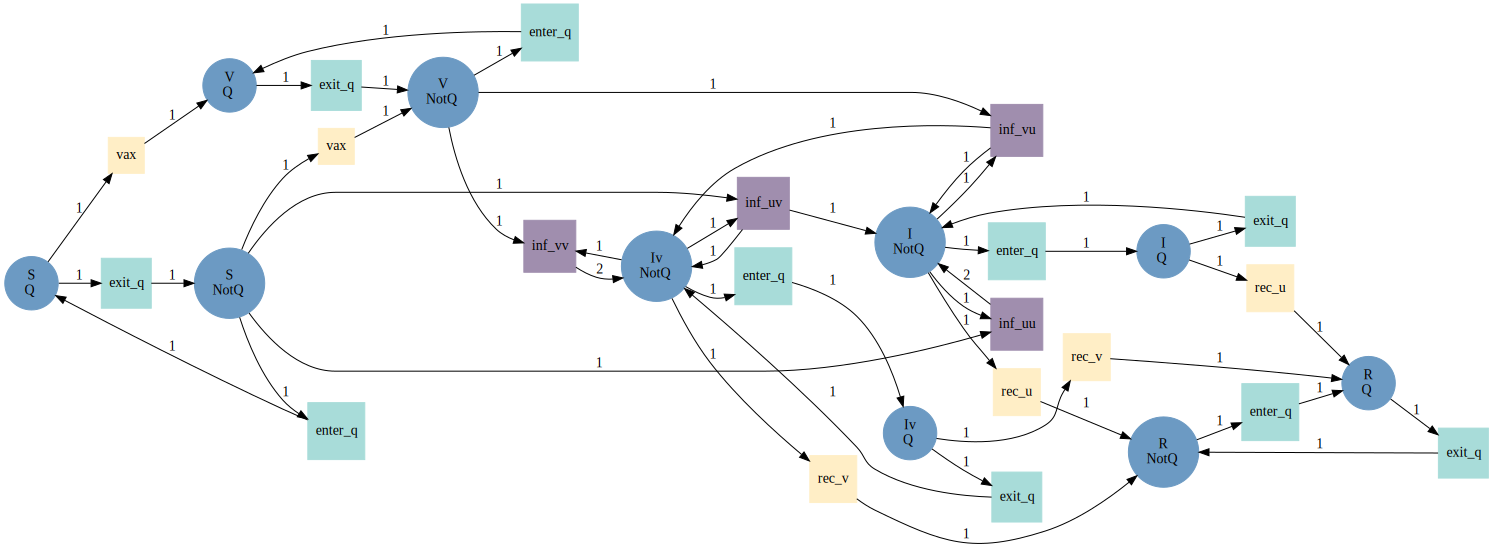

In [39]:
typed_model = typed_stratify(disease_models[:SVIIvR], typed_quarantine)
Graph_typed(typed_model)

#### Palette of stratification schemes

Our palette of stratification schemes includes the model of quarantine status (i) already implemented along with a model of age stratification (ii), and two movement models (iii and iv). 

<img width = 60% src="img/palette-strata.png">

Next, we describe and implement these additional stratification schemes.

Our second stratification scheme is a stratification by age. In this model, individuals cannot move between strata.
Individuals can  undergo a spontaneous change in their infection status as well as interact with other individuals in their strata.
Adults and children can also interact. However, the mapping of the input arcs asserts that children infect adults and not vice versa.

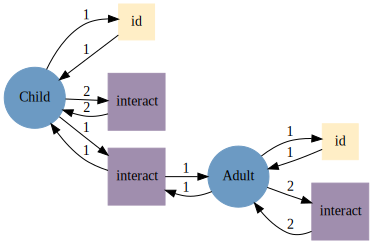

In [40]:
age_stratification = LabelledPetriNet([:Child, :Adult],
    :id => (:Child => :Child),
    :id => (:Adult => :Adult),
    :interact => ((:Child, :Child) => (:Child, :Child)),
    :interact => ((:Adult, :Adult) => (:Adult, :Adult)),
    :interact => ((:Child, :Adult) => (:Child, :Adult))
)

typed_age = ACSetTransformation(age_stratification, infectious_type,
  S = [s, s],
  T = [t_disease, t_disease, t_interact, t_interact, t_interact],
  I = [i_disease, i_disease, i_interact1, i_interact2, i_interact1, i_interact2, i_interact2, i_interact1],
  O = [o_disease, o_disease, o_interact1, o_interact2, o_interact1, o_interact2, o_interact2, o_interact1],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
);

Graph_typed(typed_age)

Our final two stratification schemes are spatial stratifications with population dynamics, which were studied in Citron et. al, 2021. In the flux model of spatial dynamics individuals move between patches and only individuals in the same patch can interact.

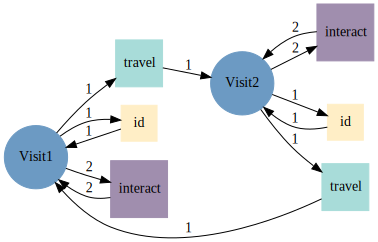

In [41]:
flux_metapopulation = LabelledPetriNet([:Visit1, :Visit2],
    :travel => (:Visit1 => :Visit2),
    :travel => (:Visit2 => :Visit1),
    :id => (:Visit1 => :Visit1),
    :id => (:Visit2 => :Visit2),
    :interact => ((:Visit1, :Visit1) => (:Visit1, :Visit1)),
    :interact => ((:Visit2, :Visit2) => (:Visit2, :Visit2))
)

typed_flux = ACSetTransformation(flux_metapopulation, infectious_type,
  S = [s, s],
  T = [t_strata, t_strata, t_disease, t_disease, t_interact, t_interact],
  I = [i_strata, i_strata, i_disease, i_disease, i_interact1, i_interact2, i_interact1, i_interact2],
  O = [o_strata, o_strata, o_disease, o_disease, o_interact1, o_interact2, o_interact1, o_interact2],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
);

Graph_typed(typed_flux)

In the simple trip model of spatial dynamics, individuals are associated to two patches: a "residence" patch
and a "currently visiting" patch. Individuals can spontaneously move between visiting a patch and returning home,
but they cannot change which patch they live in. Only individuals visiting the same patch can interact.
This model involves $N^2$ places and $O(N^2)$ transitions where $N$ is the number of patches. To
reduce the complexity of building this model, we build it as the model of where individuals live *stratified* by the flux model already implemented above.  This example highlights that stratified models can be built *hierarchically*, meaning that a stratification scheme can itself be a stratified model. 

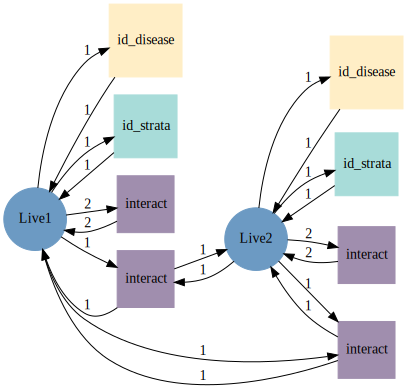

In [42]:
living_model = LabelledPetriNet([:Live1, :Live2],
    :id_disease => (:Live1, :Live1),
    :id_disease => (:Live2, :Live2),
    :id_strata => (:Live1, :Live1),
    :id_strata => (:Live2, :Live2),
    :interact => ((:Live1, :Live1) => (:Live1, :Live1)),
    :interact => ((:Live2, :Live2) => (:Live2, :Live2)),
    :interact => ((:Live1, :Live2) => (:Live1, :Live2)),
    :interact => ((:Live2, :Live1) => (:Live2, :Live1))
)

typed_living = ACSetTransformation(living_model, infectious_type,
  S = [s, s],
  T = [t_disease, t_disease, t_strata, t_strata, t_interact, t_interact, t_interact, t_interact],
  I = [i_disease, i_disease, i_strata, i_strata, i_interact1, i_interact2, i_interact1, i_interact2, i_interact1, i_interact2, i_interact1, i_interact2],
  O = [o_disease, o_disease, o_strata, o_strata, o_interact1, o_interact2, o_interact1, o_interact2, o_interact1, o_interact2, o_interact1, o_interact2],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
);

Graph_typed(typed_living)

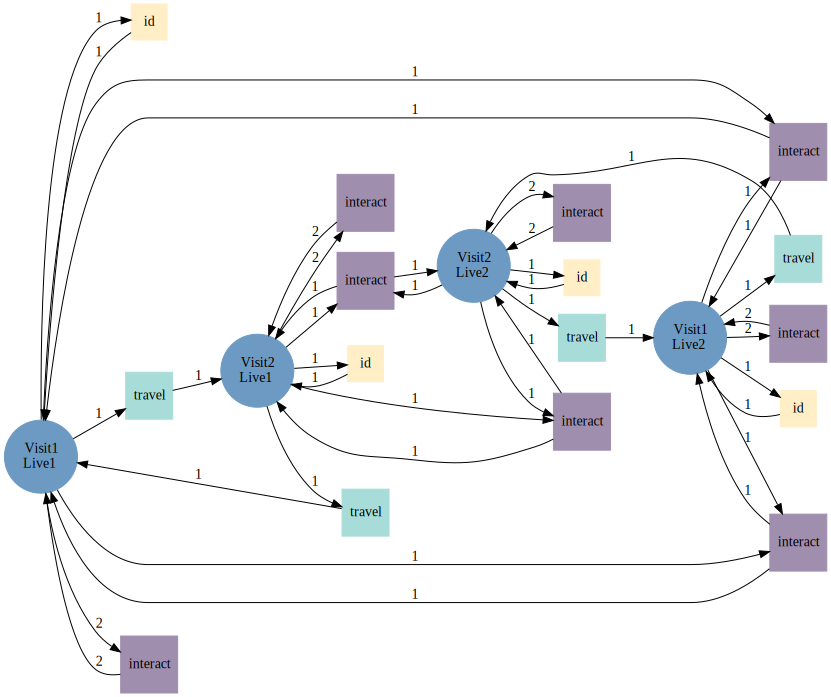

In [43]:
typed_simple_trip = typed_stratify(typed_flux, typed_living)

simple_trip = stratify(typed_flux, typed_living)

Graph_typed(typed_simple_trip)

Finally, we define our palette of stratification schemes.

In [44]:
stratification_scheme = Dict(
  :quarantine => typed_quarantine,
  :age => typed_age,
  :flux => typed_flux,
  :simple_trip => typed_simple_trip,
);

### Stratified models
Now we can stratify any disease model by any stratification scheme. For example, we can stratify the SVIIvR disease model by the age stratification scheme.

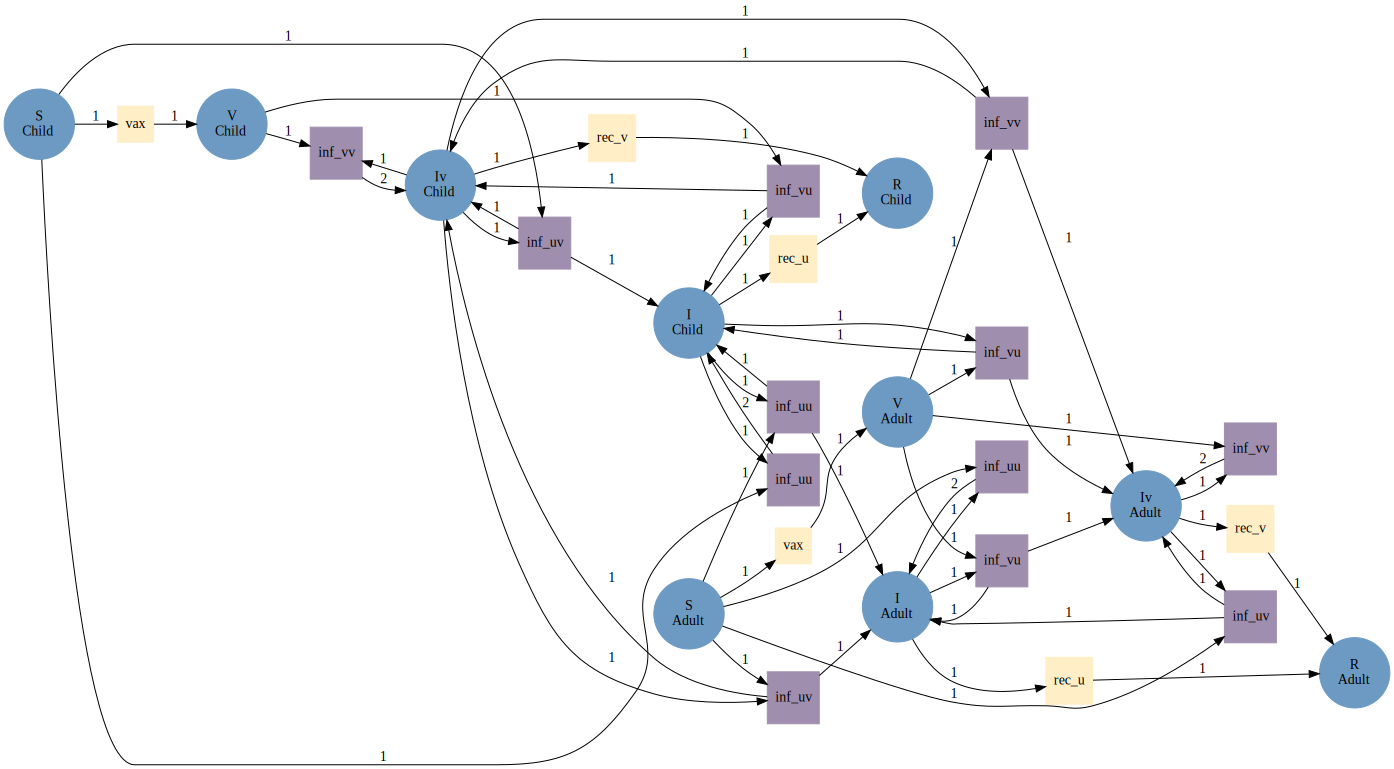

In [45]:
typed_model = typed_stratify(disease_models[:SVIIvR], stratification_scheme[:age])
Graph_typed(typed_model)

The process of model stratification automates the labor intensive approach taken in Citron et. al, 2021 for combining candidate disease models with candidate movement models in order to test against real-world data. 

Below we show how the Petri nets for SIR and SIS disease dynamics stratified by the flux and simple trip movement models are automatically generated by our approach. When the law of mass action is applied to these Petri nets, we recover the ODEs in Equations 6, 7, 9, and 10 of Citron et. al, 2021 modulo the treatment of total vs. proportional populations.

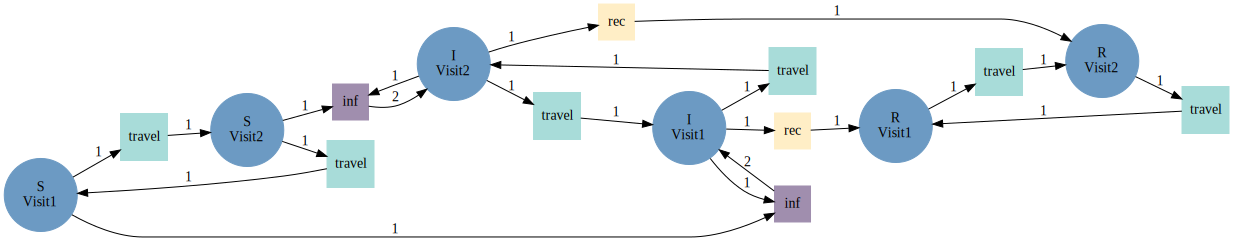

In [46]:
typed_SIR_flux = typed_stratify(disease_models[:SIR], stratification_scheme[:flux]) 
Graph_typed(typed_SIR_flux)

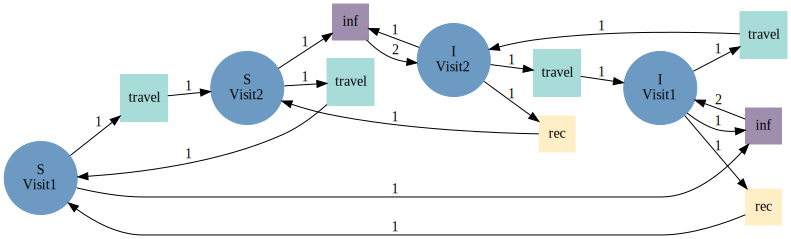

In [47]:
typed_SIS_flux = typed_stratify(disease_models[:SIS], stratification_scheme[:flux]) 
Graph_typed(typed_SIS_flux)

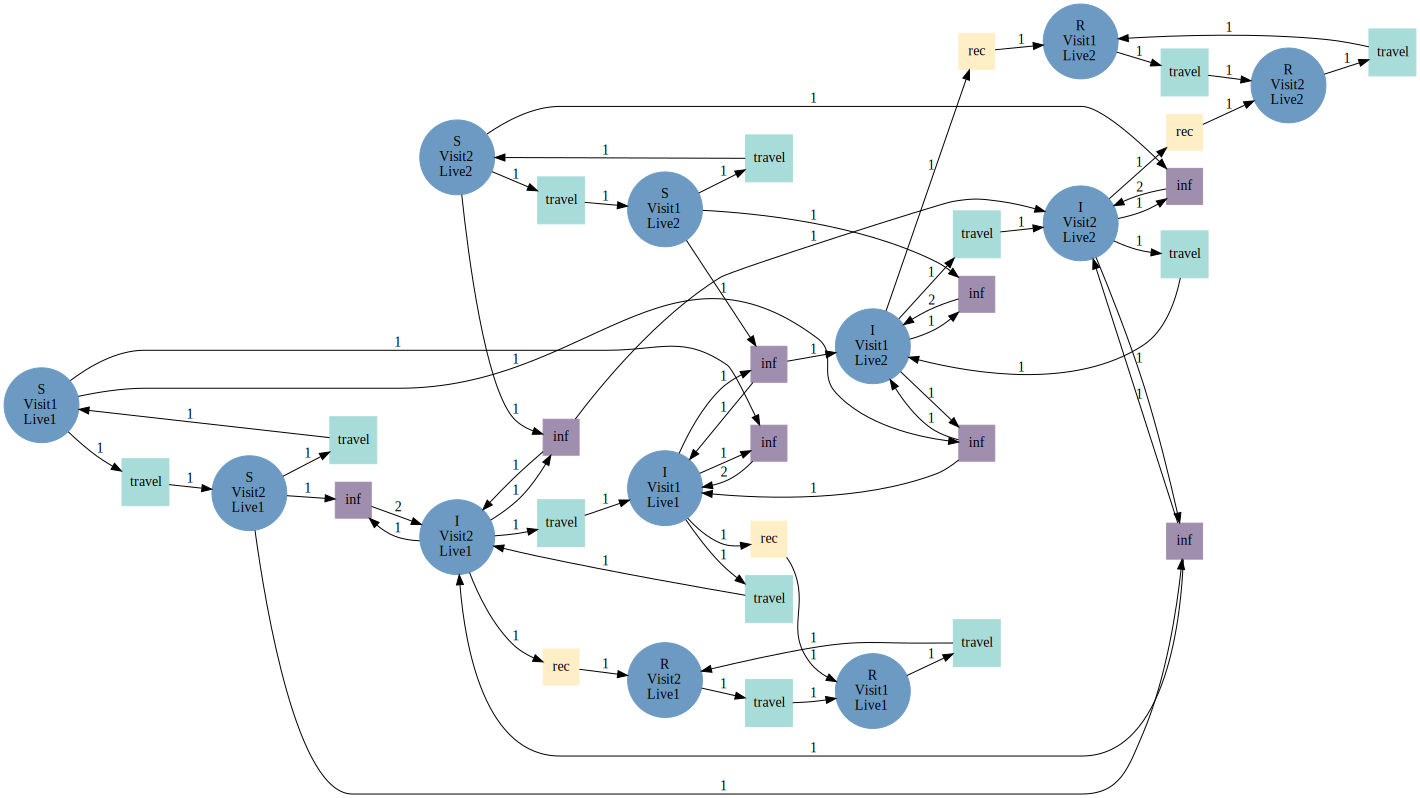

In [48]:
typed_SIR_simple_trip = typed_stratify(disease_models[:SIR], stratification_scheme[:simple_trip]) 
Graph_typed(typed_SIR_simple_trip)

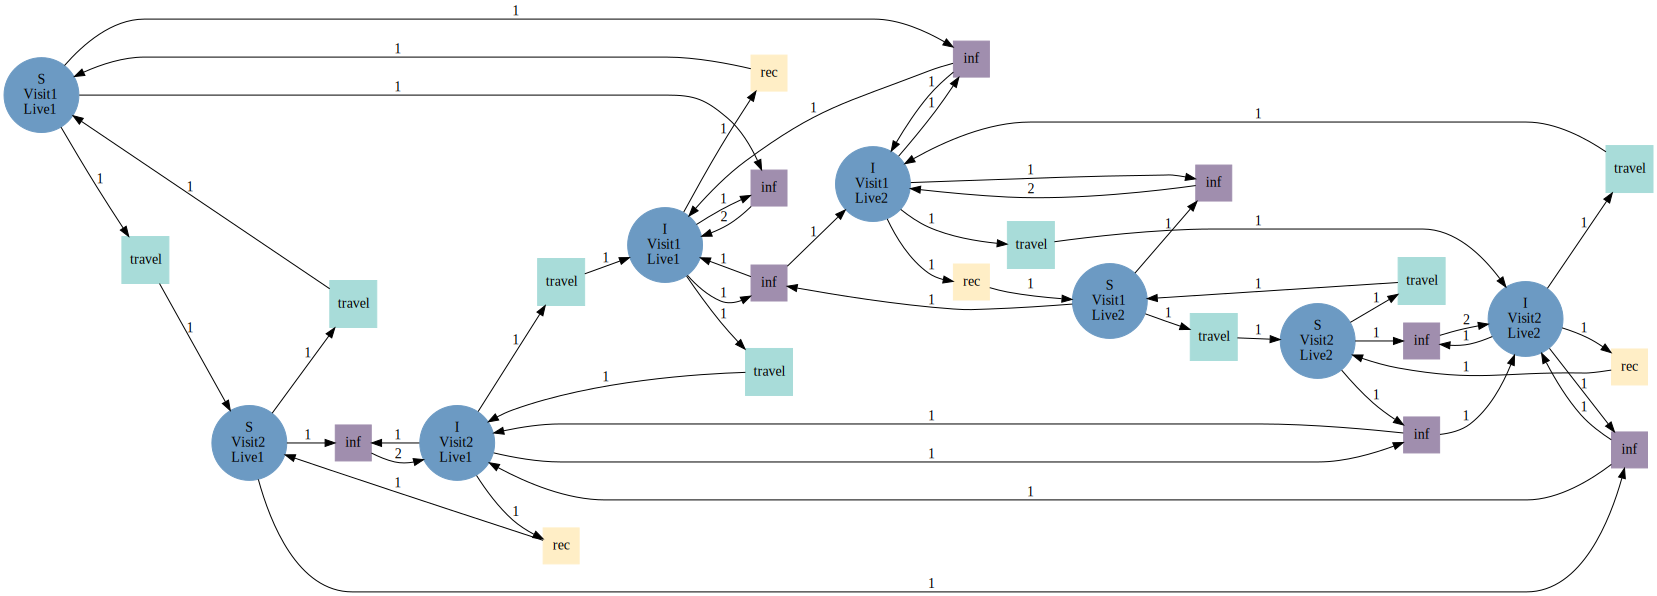

In [49]:
typed_SIS_simple_trip = typed_stratify(disease_models[:SIS], stratification_scheme[:simple_trip]) 
Graph_typed(typed_SIS_simple_trip)

The SIR and SIS simple trip models are called multiply-stratified or hierarchically-stratified models because the simple trip model is itself a stratified model. Fully decomposed, the SIS simple trip model is a 3-way stratification of the SIS disease model, the flux model, and a model of where individuals live. An important property guaranteed by the categorical formalism is that the order of stratification does not affect the final model. For example, the typed Petri net below is isomorphic to the typed Petri net given in `typed_SIS_simple_trip` above.

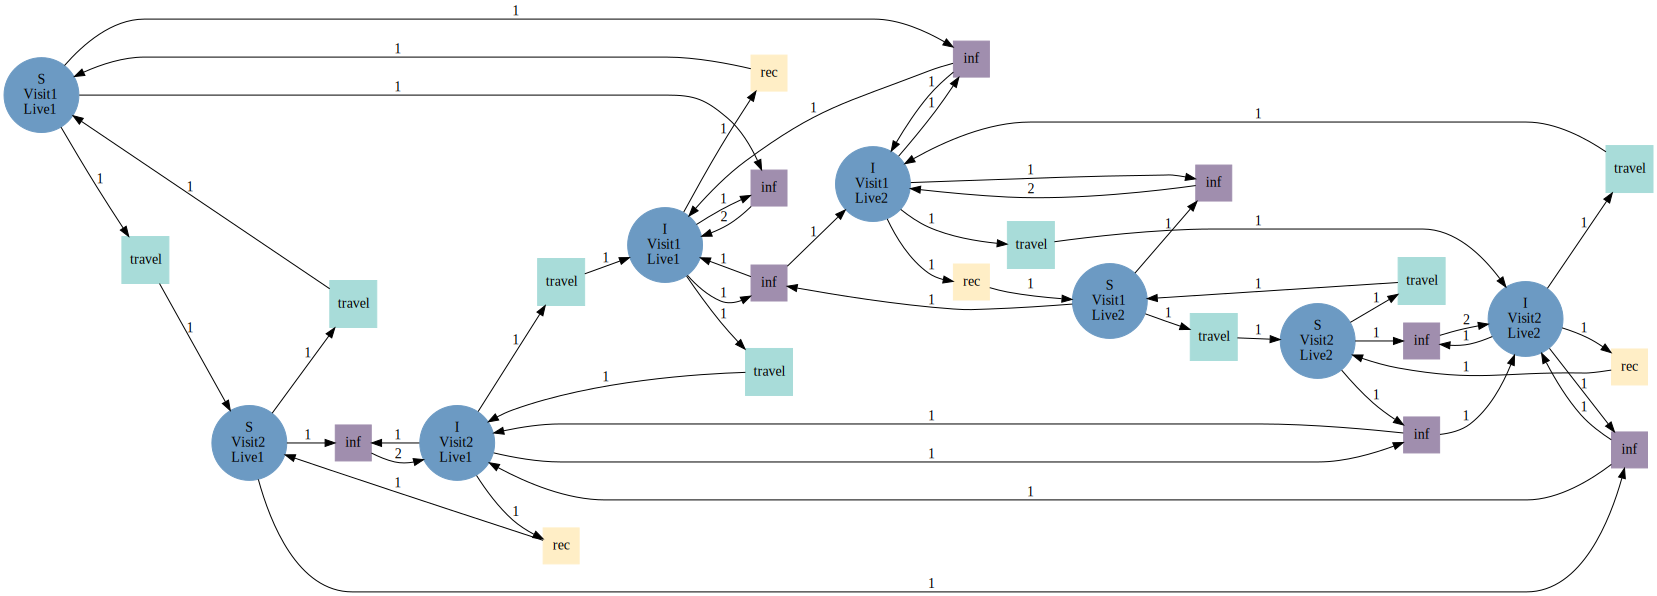

In [50]:
typed_SIS_simple_trip2 = typed_stratify(
  typed_stratify(disease_models[:SIS], stratification_scheme[:flux]), 
  typed_living
)
Graph_typed(typed_SIS_simple_trip2)

#### References

Citron, Daniel T., et al. "Comparing metapopulation dynamics of infectious diseases under different models of human movement." _Proceedings of the National Academy of Sciences_ 118.18 (2021).

In [68]:
modls = [infectious_type,
         vector_borne_type,
         SIR|>apex, SIS, VIvR|>apex,
         quarantine,
         cross_exposure|>apex,
         SVIIvR,
         flux_metapopulation,
         living_model,
         dom(typed_SIR_flux),
         dom(typed_SIS_flux),
         dom(typed_SIR_simple_trip),
         dom(typed_SIS_simple_trip),
         dom(typed_SIS_simple_trip2)
         ]
names = ["infectious_type",
         "vector_borne_type",
         "SIR", "SIS", "VIvR",
         "quarantine",
         "cross_exposure",
         "SVIIvR",
         "flux_metapopulation",
         "living_model",
         "SIR_flux",
         "SIS_flux",
         "SIR_simple_trip",
         "SIS_simple_trip",
         "SIS_simple_trip2"
         ]

for (modl, name) in zip(modls, names) 
  open("data/$name.json", "w") do io
    write(io, generate_json_acset(modl))
  end;
end
